<a href="https://www.kaggle.com/code/shakibahamed13/hyperspectral-image-classification-cnn?scriptVersionId=257948838" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#set up the environment, import essential libraries, and check for GPU
# Basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


# Sklearn for data splitting and encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kinggleliu/hyperspectral-image-classification-data-collection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/hyperspectral-image-classification-data-collection


In [3]:
# Cell: Check dataset folder structure

import os

root_path = '/kaggle/input/hyperspectral-image-classification-data-collection'

for root, dirs, files in os.walk(root_path):
    print(f"Directory: {root}")
    for file in files:
        if file.endswith('.mat'):
            print(f"  File: {file}")

Directory: /kaggle/input/hyperspectral-image-classification-data-collection
Directory: /kaggle/input/hyperspectral-image-classification-data-collection/datasets
Directory: /kaggle/input/hyperspectral-image-classification-data-collection/datasets/HyRANK
  File: Loukia_gt_out68.mat
  File: Dioni_gt.mat
  File: Loukia.mat
  File: Loukia_gt.mat
  File: Dioni.mat
Directory: /kaggle/input/hyperspectral-image-classification-data-collection/datasets/pu
  File: paviaC.mat
  File: paviaC_7gt.mat
  File: paviaU.mat
  File: paviaU_7gt.mat
Directory: /kaggle/input/hyperspectral-image-classification-data-collection/datasets/Huston
  File: Houston13.mat
  File: Houston18.mat
  File: Houston18_7gt.mat
  File: Houston13_7gt.mat
Directory: /kaggle/input/hyperspectral-image-classification-data-collection/datasets/ip
  File: Indian_pines_corrected.mat
  File: Indian_pines.mat
  File: Indian_pines_gt.mat
Directory: /kaggle/input/hyperspectral-image-classification-data-collection/datasets/sa
  File: Salinas

In [4]:
# === HyRANK loader (new cell) ===
import os
import scipy.io

# --- CONFIG ---
chosen_dataset = "hyrank"    # "ip", "pu", "sa", "houston", "hyrank"
chosen_scene = "Loukia"      # For HyRANK: "Loukia" or "Dioni"

base_path = "/kaggle/input/hyperspectral-image-classification-data-collection/datasets"

# --- Dataset folder mapping (unchanged) ---
dataset_folders = {
    "ip": "ip",
    "pu": "pu",
    "sa": "sa",
    "houston": "Huston",
    "hyrank": "HyRANK"
}

def load_dataset(dataset_key, scene_name=None):
    folder = dataset_folders[dataset_key]
    dataset_path = os.path.join(base_path, folder)

    mat_files = [f for f in os.listdir(dataset_path) if f.endswith(".mat")]
    if not mat_files:
        raise FileNotFoundError(f"No .mat files found in {dataset_path}")

    if dataset_key == "pu":
        if scene_name is None:
            raise ValueError("For 'pu', set chosen_scene to 'paviaU' or 'paviaC'")
        image_file = next((f for f in mat_files if scene_name.lower() in f.lower() and "gt" not in f.lower()), None)
        label_file = next((f for f in mat_files if scene_name.lower() in f.lower() and "gt" in f.lower()), None)

    elif dataset_key == "hyrank":
        if scene_name is None:
            raise ValueError("For 'hyrank', set chosen_scene to 'Loukia' or 'Dioni'")
        # Image by scene
        image_file = next((f for f in mat_files if scene_name.lower() in f.lower() and "gt" not in f.lower()), None)
        # Labels by scene; prefer standard *_gt.mat over variants like *_gt_out*.mat
        label_candidates = [f for f in mat_files if scene_name.lower() in f.lower() and "gt" in f.lower()]
        label_file = next((f for f in label_candidates if "out" not in f.lower()), None) or (label_candidates[0] if label_candidates else None)

    else:
        image_file = next((f for f in mat_files if "gt" not in f.lower()), None)
        label_file = next((f for f in mat_files if "gt" in f.lower()), None)

    if not image_file or not label_file:
        raise ValueError(f"Could not detect image/label files in {dataset_path} for scene '{scene_name}'")

    image_path = os.path.join(dataset_path, image_file)
    label_path = os.path.join(dataset_path, label_file)

    image_mat = scipy.io.loadmat(image_path)
    label_mat = scipy.io.loadmat(label_path)

    image_key = [k for k in image_mat.keys() if not k.startswith("__")][0]
    label_key = [k for k in label_mat.keys() if not k.startswith("__")][0]

    data_cube = image_mat[image_key]
    labels = label_mat[label_key]

    print(f"✅ Loaded dataset: {dataset_key} ({scene_name if scene_name else ''})")
    print(f"Image file: {image_file}  |  Label file: {label_file}")
    print("Data shape:", data_cube.shape)
    print("Labels shape:", labels.shape)

    return data_cube, labels

# --- Load selected dataset ---
data_cube, labels = load_dataset(chosen_dataset, scene_name=chosen_scene if chosen_dataset in ["pu", "hyrank"] else None)

✅ Loaded dataset: hyrank (Loukia)
Image file: Loukia.mat  |  Label file: Loukia_gt.mat
Data shape: (249, 945, 176)
Labels shape: (249, 945)


In [5]:
# === Dataset summary (new cell) ===
import numpy as np

# Friendly names for display only (doesn't change your variables)
_ds_names = {"ip": "Indian Pines", "pu": "Pavia University", "sa": "Salinas", "houston": "Houston", "hyrank": "HyRANK"}
_scene = chosen_scene if "chosen_scene" in globals() else None
_ds_key = chosen_dataset if "chosen_dataset" in globals() else "unknown"
_dataset_name = f"{_ds_names.get(_ds_key, _ds_key)}" + (f" - {_scene}" if _scene else "")

# Source (based on your earlier download cell)
_dataset_source = "Kaggle dataset: kinggleliu/hyperspectral-image-classification-data-collection"

# Core shapes and types
H, W, B = data_cube.shape
data_dtype = str(data_cube.dtype)
labels_dtype = str(labels.dtype)

# Label info (exclude 0 = unlabeled)
_nonzero_labels = labels[labels != 0]
num_classes_from_labels = int(len(np.unique(_nonzero_labels)))
label_values = sorted(int(v) for v in np.unique(_nonzero_labels))

# Inputs actually used by the model/training
if "X_train" in globals():
    bands_used = int(X_train.shape[2])
    patch_h, patch_w = int(X_train.shape[3]), int(X_train.shape[4])
    example_input_shape = tuple(X_train.shape[1:])  # (1, bands, H, W)
else:
    bands_used = B
    patch_h = patch_w = 7  # default used in your code
    example_input_shape = (1, B, patch_h, patch_w)

# Output label indexing after your preprocessing (y = y - 1)
if "y_train" in globals():
    y_unique = np.unique(y_train.cpu().numpy() if hasattr(y_train, "cpu") else y_train)
    num_classes_model = int(len(y_unique))
    label_range_0_based = f"{int(y_unique.min())}..{int(y_unique.max())}"
else:
    num_classes_model = num_classes_from_labels
    label_range_0_based = f"0..{num_classes_from_labels-1}"

# Print the report
print("=== Dataset Name & Source ===")
print(f"- Name:   {_dataset_name}")
print(f"- Source: {_dataset_source}")

print("\n=== Description ===")
print(f"- Data size:      {H} (height) x {W} (width) x {B} (bands)")
print(f"- Labels size:    {labels.shape} (0 = unlabeled)")
print(f"- Number of classes (from labels, excl. 0): {num_classes_from_labels} | Labels: {label_values}")
print(f"- Data dtype:     {data_dtype}")
print(f"- Labels dtype:   {labels_dtype}")

print("\n=== Inputs (features/bands) ===")
print(f"- Bands used:     {bands_used} of {B}")
print(f"- Patch size:     {patch_h} x {patch_w}")
print(f"- Model input example shape (C, Bands, H, W): {example_input_shape}")

print("\n=== Outputs (labels/predictions) ===")
print(f"- Number of classes (model): {num_classes_model}")
print(f"- Label indexing (after preprocessing y=y-1): {label_range_0_based}")
print(f"- Prediction type: Single-class classification per patch/pixel")

=== Dataset Name & Source ===
- Name:   HyRANK - Loukia
- Source: Kaggle dataset: kinggleliu/hyperspectral-image-classification-data-collection

=== Description ===
- Data size:      249 (height) x 945 (width) x 176 (bands)
- Labels size:    (249, 945) (0 = unlabeled)
- Number of classes (from labels, excl. 0): 14 | Labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
- Data dtype:     uint16
- Labels dtype:   uint8

=== Inputs (features/bands) ===
- Bands used:     176 of 176
- Patch size:     7 x 7
- Model input example shape (C, Bands, H, W): (1, 176, 7, 7)

=== Outputs (labels/predictions) ===
- Number of classes (model): 14
- Label indexing (after preprocessing y=y-1): 0..13
- Prediction type: Single-class classification per patch/pixel


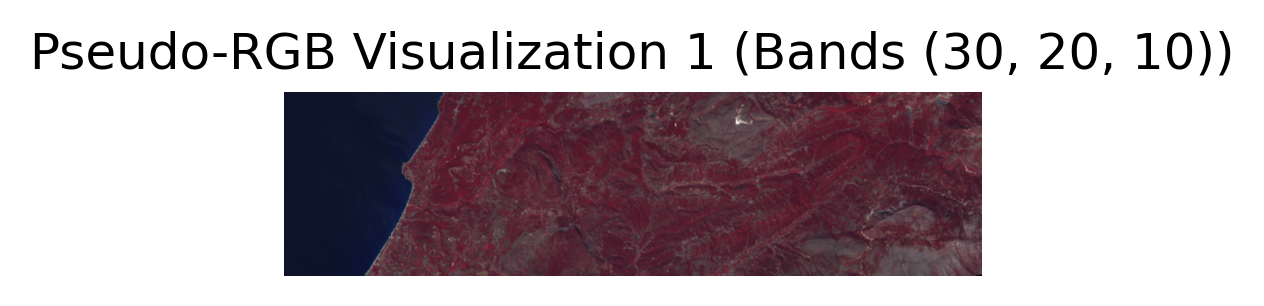

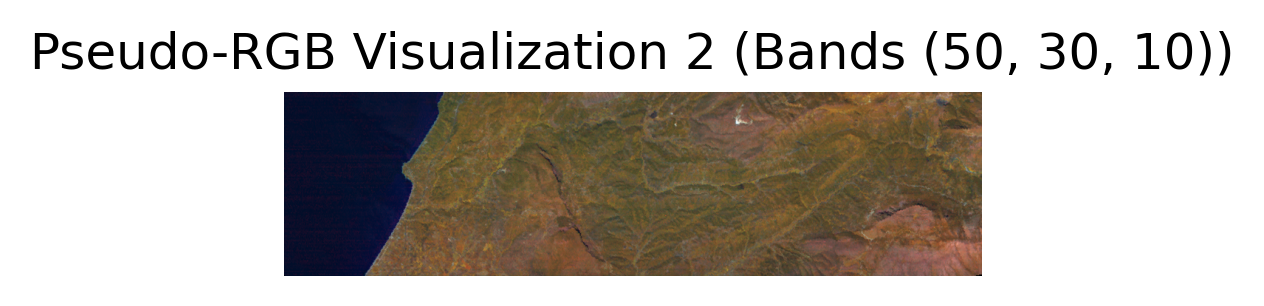

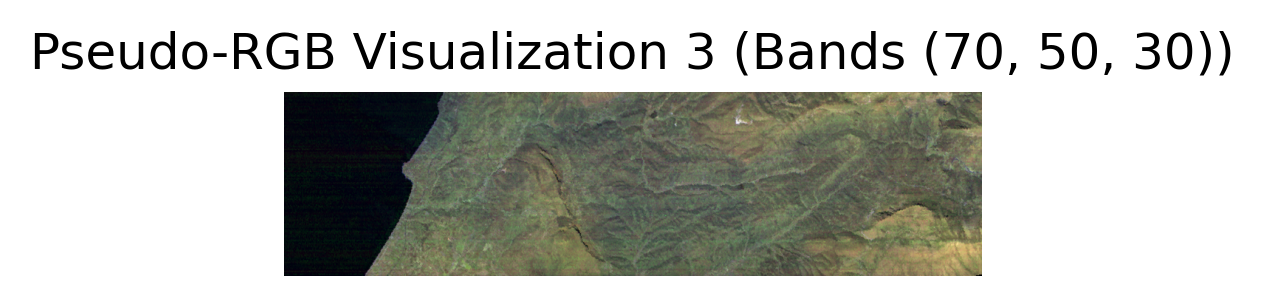

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# === 5 Band Combinations for RGB Visualization ===
band_sets = [
    (30, 20, 10),   # Set 1
    (50, 30, 10),   # Set 2
    (70, 50, 30),   # Set 3
     # Set 5 (works only if dataset has enough bands)
]

# === Customize Figure Size & DPI ===
fig_size = (3, 3)  # width x height in inches
save_dpi = 300       # High resolution

# === Normalize Each Band (0 to 1) ===
def normalize_band(band):
    return (band - np.min(band)) / (np.max(band) - np.min(band))

# === Generate and Save Images ===
for i, bands in enumerate(band_sets, start=1):
    # Extract and normalize bands
    r = normalize_band(data_cube[:, :, bands[0]])
    g = normalize_band(data_cube[:, :, bands[1]])
    b = normalize_band(data_cube[:, :, bands[2]])
    
    # Stack into RGB
    rgb_image = np.stack((r, g, b), axis=-1)

    # Show image
    plt.figure(figsize=fig_size, dpi=save_dpi)
    plt.imshow(rgb_image)
    plt.title(f"Pseudo-RGB Visualization {i} (Bands {bands})")
    plt.axis("off")

    # Save as PNG
    plt.savefig(f"rgb_visualization_{i}_bands_{bands[0]}_{bands[1]}_{bands[2]}.png",
                dpi=save_dpi, bbox_inches='tight')
    plt.show()

In [7]:
#Normalize the Hyperspectral Cube
# Min-Max Normalization per spectral band
def normalize_cube(cube):
    norm_cube = np.zeros_like(cube, dtype=np.float32)
    for b in range(cube.shape[2]):
        band = cube[:, :, b]
        min_val = np.min(band)
        max_val = np.max(band)
        norm_cube[:, :, b] = (band - min_val) / (max_val - min_val + 1e-6)
    return norm_cube

data_norm_cube = normalize_cube(data_cube)
print("✅ Normalization complete!")

✅ Normalization complete!


In [8]:

def extract_3d_patches(data_cube, labels, patch_size=7):
    """
    Extract 3D patches of size patch_size x patch_size around each labeled pixel.
    Pads the data_cube to handle border pixels.
    Args:
      data_cube: numpy array of shape (height, width, bands)
      labels: 2D numpy array of shape (height, width)
      patch_size: size of the spatial patch (should be odd)
    Returns:
      X: numpy array of extracted patches (num_samples, patch_size, patch_size, bands)
      y: corresponding labels (num_samples,)
    """
    margin = patch_size // 2
    # Pad the spatial dimensions to allow patch extraction at edges
    padded_data = np.pad(data_cube, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    
    X = []
    y = []

    rows, cols = labels.shape
    for i in range(rows):
        for j in range(cols):
            label = labels[i, j]
            if label != 0:  # Ignore unlabeled pixels (label=0)
                # Extract patch centered at (i,j) from padded data
                patch = padded_data[i:i+patch_size, j:j+patch_size, :]
                X.append(patch)
                y.append(label)

    # Convert lists to numpy arrays for further processing
    X = np.array(X)
    y = np.array(y)
    return X, y

# Run patch extraction on normalized data and labels
X, y = extract_3d_patches(data_norm_cube, labels, patch_size=7)

print("✅ Patch extraction complete!")
print("X shape (samples, height, width, spectral bands):", X.shape)
print("y shape:", y.shape)

✅ Patch extraction complete!
X shape (samples, height, width, spectral bands): (13503, 7, 7, 176)
y shape: (13503,)


In [9]:
from sklearn.model_selection import train_test_split
import torch
# Reshape patches from (N, H, W, C) to (N, C, H, W) for PyTorch Conv3D compatibility
X = np.transpose(X, (0, 3, 1, 2))  # Now (num_samples, bands, height, width)
# Add channel dimension (channels=1) for 3D convolution input
# Final shape: (num_samples, 1, bands, height, width)
X = np.expand_dims(X, axis=1)
# Normalize labels to 0-based indexing (PyTorch expects class indices starting at 0)
y = y - 1
# Split dataset into training and testing subsets with stratification to maintain label distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
# Convert numpy arrays to PyTorch tensors with appropriate types
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)
print("✅ Data ready for 3D-CNN")
print("Train shape:", X_train.shape)  # Expect (num_train_samples, 1, bands, height, width)
print("Test shape:", X_test.shape)

✅ Data ready for 3D-CNN
Train shape: torch.Size([10127, 1, 176, 7, 7])
Test shape: torch.Size([3376, 1, 176, 7, 7])


In [10]:
from torch.utils.data import TensorDataset, DataLoader

# Wrap tensors in TensorDataset for easy batch access
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders for efficient mini-batch loading during training/testing
# batch_size=64 chosen here, shuffle training data for randomness
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("✅ DataLoaders created successfully!")
print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")

✅ DataLoaders created successfully!
Train batches: 159, Test batches: 53


In [11]:
#Model Definition

import torch
import torch.nn as nn
import torch.nn.functional as F

class Hybrid3DCNNTransformer(nn.Module):
    def __init__(self, input_channels=1, patch_size=7, bands=102, num_classes=16):
        super(Hybrid3DCNNTransformer, self).__init__()

        # 3D CNN block for spectral-spatial feature extraction
        self.cnn3d = nn.Sequential(
            nn.Conv3d(in_channels=input_channels, out_channels=8, kernel_size=(7, 3, 3), padding=(0, 1, 1)),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.Conv3d(8, 16, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU()
        )

        # Compute the flattened size of CNN output dynamically using a dummy tensor
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_channels, bands, patch_size, patch_size)
            dummy_output = self.cnn3d(dummy_input)
            flattened_size = dummy_output.numel()  # total elements in CNN output tensor
        
        # Linear layer to embed CNN features for Transformer input
        self.embedding_dim = 512
        self.fc_embed = nn.Linear(flattened_size, self.embedding_dim)

        # Transformer Encoder with batch_first=True for easier batch handling
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.embedding_dim, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)

        # Final classifier to output num_classes predictions
        self.classifier = nn.Linear(self.embedding_dim, num_classes)

    def forward(self, x):
        # Input shape: (batch_size, channels=1, spectral bands, height, width)
        x = self.cnn3d(x)               # CNN feature extraction
        x = torch.flatten(x, start_dim=1)  # Flatten all but batch dimension
        x = self.fc_embed(x).unsqueeze(1)  # Embed and add seq_len=1 dimension for Transformer
        x = self.transformer(x)             # Transformer Encoder
        x = x.squeeze(1)                   # Remove seq_len dimension
        x = self.classifier(x)             # Classification layer
        return x

print("✅ Hybrid 3D CNN Transformer model defined successfully with dynamic flatten size!")

✅ Hybrid 3D CNN Transformer model defined successfully with dynamic flatten size!


In [12]:
print("Actual bands:", X_train.shape[2])
print("Full X_train shape:", X_train.shape)

Actual bands: 176
Full X_train shape: torch.Size([10127, 1, 176, 7, 7])


In [13]:
# Count trainable parameters function
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Instantiate model and count Loaded dataset: pu (paviaU)
# model = Hybrid3DCNNTransformer(input_channels=1, patch_size=7, bands=102, num_classes=16)
# total_params = count_parameters(model)


# Instantiate model and count  Loaded dataset: hyrank (Loukia)
model = Hybrid3DCNNTransformer(input_channels=1, patch_size=7, bands=176, num_classes=16)
total_params = count_parameters(model)


print(f"🧮 Total Trainable Parameters: {total_params:,}")

🧮 Total Trainable Parameters: 71,404,496


In [14]:
print("Before training, checking input batch shape:")
for X_batch, y_batch in train_loader:
    print("Batch shape:", X_batch.shape)
    # If shape is 6D, remove extra dimension
    if X_batch.dim() == 6:
        X_batch = X_batch.squeeze(2)
        print("Squeezed to:", X_batch.shape)
    break

Before training, checking input batch shape:
Batch shape: torch.Size([64, 1, 176, 7, 7])


In [15]:


# Initialize Model, Loss, Optimizer

import torch
import torch.nn as nn

# Select device automatically: GPU if available else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate model with correct input/output sizes
# Use the actual number of bands from data to avoid mismatches
model = Hybrid3DCNNTransformer(
    input_channels=1,
    patch_size=7,
    bands=int(X_train.shape[2]),  # <-- FIX: match 102 bands from data
    num_classes=len(torch.unique(y_train))
).to(device)

# Cross-entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# Adam optimizer with learning rate 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

print("✅ Model, Loss, and Optimizer are ready.")

Using device: cuda
✅ Model, Loss, and Optimizer are ready.


In [16]:
# Define the Training Loop
# This cell trains the hybrid 3D-CNN + Transformer model using the training data and evaluates on the test set.

def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=20):
    best_test_acc = 0.0

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Evaluation on test set
        model.eval()
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted_test = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted_test == labels).sum().item()

        test_acc = 100 * correct_test / total_test

        print(f"Epoch {epoch}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Accuracy: {train_acc:.2f}%, "
              f"Test Accuracy: {test_acc:.2f}%")

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Save best model based on test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), "best_hybrid_model.pt")
            print("Best model updated.\n")

    print(f"Training complete! Best Test Accuracy: {best_test_acc:.2f}%")

    return train_losses, train_accuracies, test_accuracies

In [17]:
#Run training and collect metrics

epochs = 10
train_losses, train_accs, test_accs = train_model(model, train_loader, test_loader, criterion, optimizer, epochs=epochs)

Epoch 1/10, Train Loss: 1.3190, Train Accuracy: 55.40%, Test Accuracy: 70.53%
Best model updated.

Epoch 2/10, Train Loss: 0.7076, Train Accuracy: 73.85%, Test Accuracy: 75.86%
Best model updated.

Epoch 3/10, Train Loss: 0.4723, Train Accuracy: 82.26%, Test Accuracy: 80.39%
Best model updated.

Epoch 4/10, Train Loss: 0.3673, Train Accuracy: 86.19%, Test Accuracy: 84.77%
Best model updated.

Epoch 5/10, Train Loss: 0.3215, Train Accuracy: 87.96%, Test Accuracy: 87.00%
Best model updated.

Epoch 6/10, Train Loss: 0.2498, Train Accuracy: 90.45%, Test Accuracy: 87.62%
Best model updated.

Epoch 7/10, Train Loss: 0.2224, Train Accuracy: 91.61%, Test Accuracy: 89.99%
Best model updated.

Epoch 8/10, Train Loss: 0.1771, Train Accuracy: 93.36%, Test Accuracy: 87.65%
Epoch 9/10, Train Loss: 0.1350, Train Accuracy: 95.20%, Test Accuracy: 86.37%
Epoch 10/10, Train Loss: 0.1263, Train Accuracy: 95.55%, Test Accuracy: 86.67%
Training complete! Best Test Accuracy: 89.99%


In [18]:
# Total parameters
total_params = sum(p.numel() for p in model.parameters())

# Trainable parameters only
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters in model: {total_params}")
print(f"Trainable parameters in model: {trainable_params}")

Total parameters in model: 71403470
Trainable parameters in model: 71403470


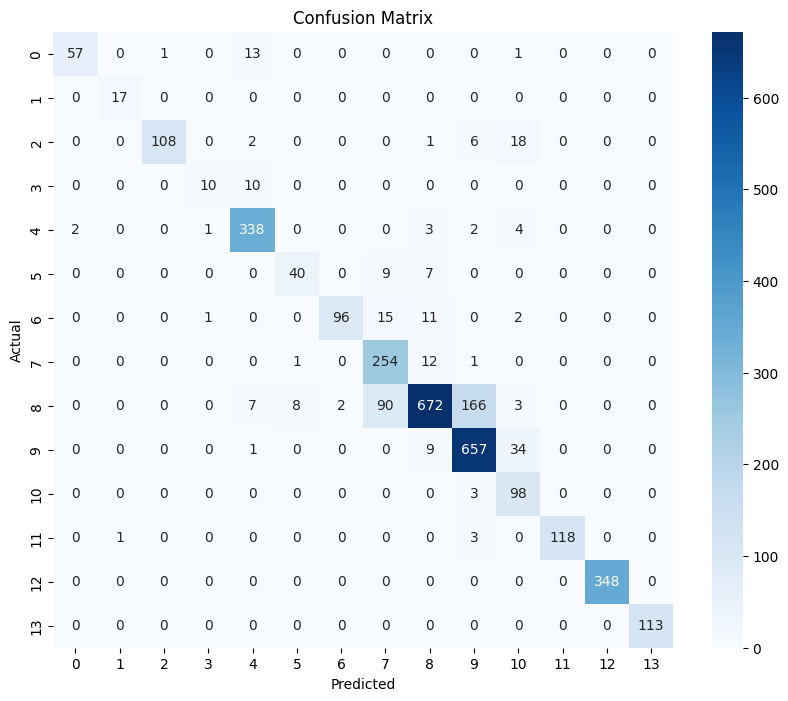

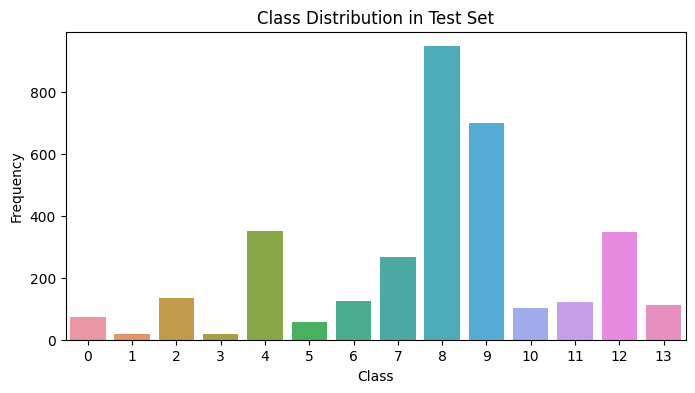

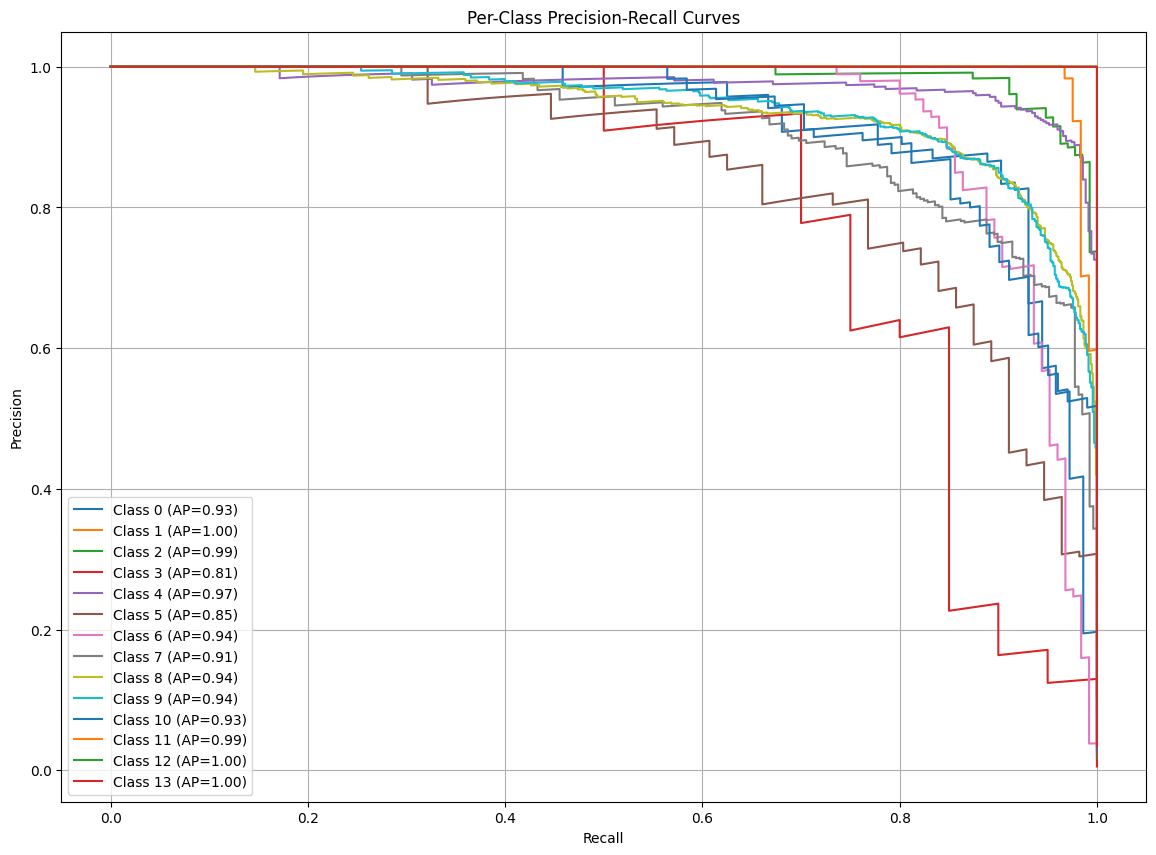

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure model is in evaluation mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 1. Classification report
class_report = classification_report(all_labels, all_preds, output_dict=True, digits=4)
df_report = pd.DataFrame(class_report).transpose()

# 2. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3. Class distribution
unique, counts = np.unique(all_labels, return_counts=True)
plt.figure(figsize=(8, 4))
sns.barplot(x=unique, y=counts)
plt.title("Class Distribution in Test Set")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# 4. Precision-Recall Curves (for multi-class)
probs = []
labels = []
model.eval()

with torch.no_grad():
    for inputs, lbls in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs.extend(outputs.cpu().numpy())
        labels.extend(lbls.cpu().numpy())

probs = np.array(probs)
labels = np.array(labels)
n_classes = probs.shape[1]

plt.figure(figsize=(14, 10))
for i in range(n_classes):
    y_true = (labels == i).astype(int)
    y_scores = probs[:, i]
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    plt.plot(recall, precision, label=f"Class {i} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Per-Class Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

In [20]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.0 MB/s eta 0:00:00


Plot saved as training_curves.png


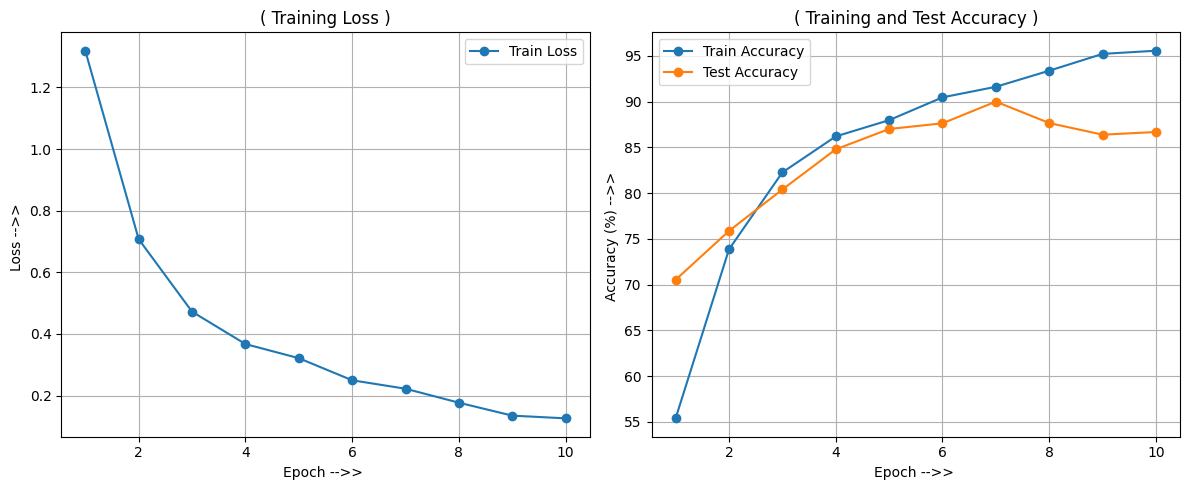

In [21]:
import matplotlib.pyplot as plt

# Create the figure
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', marker='o')
plt.xlabel('Epoch -->> ')
plt.ylabel('Loss -->> ')
plt.title('( Training Loss )')
plt.grid(True)
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accs, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs + 1), test_accs, label='Test Accuracy', marker='o')
plt.xlabel('Epoch -->> ')
plt.ylabel('Accuracy (%) -->> ')
plt.title('( Training and Test Accuracy )')
plt.grid(True)
plt.legend()

plt.tight_layout()

# ✅ Save the figure
plt.savefig("training_curves.png", dpi=300)

print("Plot saved as training_curves.png")

In [22]:
import shutil

# Move the saved file to /kaggle/working so you can download it from the sidebar
shutil.move("training_curves.png", "/kaggle/working/training_curves.png")

'/kaggle/working/training_curves.png'

In [23]:
# detailed accuracy results per class (precision, recall, F1-score, support) from 
# my CNN hybrid model, using sklearn.metrics.classification_report

from sklearn.metrics import classification_report
import torch

def get_detailed_classification_report(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    print("Detailed classification report:\n")
    print(report)

# Example usage:
class_names = [f"Class {i}" for i in range(len(torch.unique(y_train)))]  # or use actual class names if available
get_detailed_classification_report(model, test_loader, device, class_names=class_names)

Detailed classification report:

              precision    recall  f1-score   support

     Class 0     0.9661    0.7917    0.8702        72
     Class 1     0.9444    1.0000    0.9714        17
     Class 2     0.9908    0.8000    0.8852       135
     Class 3     0.8333    0.5000    0.6250        20
     Class 4     0.9111    0.9657    0.9376       350
     Class 5     0.8163    0.7143    0.7619        56
     Class 6     0.9796    0.7680    0.8610       125
     Class 7     0.6902    0.9478    0.7987       268
     Class 8     0.9399    0.7089    0.8082       948
     Class 9     0.7840    0.9372    0.8538       701
    Class 10     0.6125    0.9703    0.7510       101
    Class 11     1.0000    0.9672    0.9833       122
    Class 12     1.0000    1.0000    1.0000       348
    Class 13     1.0000    1.0000    1.0000       113

    accuracy                         0.8667      3376
   macro avg     0.8906    0.8622    0.8648      3376
weighted avg     0.8867    0.8667    0.8665    